In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
from matplotlib import pyplot as plt
from pathlib import Path
from jax.scipy.linalg import expm

from scripts.models import LinearFlow, LinearFlowWithBias, MLP, ConcatMLP, Autoencoder, SharedWeightAutoencoder, AntiSymmetricLinearFlow, KoopmanAE
from scripts.distributions import sample_multimodal_gaussian, multimodal_gaussian_pdf, multimodal_gaussian_logpdf, get_hypersphere_modes, define_distributions, estimate_evolved_means, find_orthogonal_points_symmetric, find_3_orthogonal_points
from scripts.utils.distribution_statistics import w_mu_plus_minus, kl_divergence_target_vs_learned, stable_rank_svd, plot_distribution_histogram_parallel, plot_distribution_histogram_perpendicular, get_linear_summary_stats, get_minimum_summary_stats
from scripts.utils.ode_solver import phi
from scripts.utils.plotting import make_fig_ax
from scripts.utils.analytic_gradient_calculation import compute_gradient_symmetric, compute_analytic_gradient_2modes, compute_analytic_gradient_Mmodes

#### Load a model

In [2]:
model_dict = {
    'linear': LinearFlow,
    'linear_with_bias': LinearFlowWithBias,
    'linear_antisym': AntiSymmetricLinearFlow,
    'mlp': MLP,
    'autoencoder': Autoencoder,
    'shared_weight_autoencoder': SharedWeightAutoencoder,
    'concat': ConcatMLP,
    'koopman': KoopmanAE
}

# model args:
# antisym=(dim, key, init_var)
# linear=(dim, key, init_var, init_weight)
# concat=(datasize, width, depth, key, init_std)
# mlp=(dim, width, depth, hidden_act, final_act, init_std, key)

In [64]:
def load_model(fname, dim, model_type, args, epochs, weights=True, ranks_grads=True):

    # Create model skeleton
    model_skeleton = model_dict[model_type](*args)
    
    # Create data skeletons
    losses_skeleton = jnp.empty(epochs)
    weights_skeleton = jnp.empty((epochs, dim, dim)) if weights else jnp.empty(0)
    biases_skeleton = jnp.empty(0)
    if model_type == 'mlp':
        ranks_skeleton = jnp.empty((epochs, 2))
    else:
        ranks_skeleton = jnp.empty((epochs)) if ranks_grads else jnp.empty(0)
    grads_skeleton = jnp.empty((epochs, dim, dim)) if ranks_grads else jnp.empty(0)
    skeleton = {'model': model_skeleton,
                'losses': losses_skeleton,
                'weights': weights_skeleton,
                'biases': biases_skeleton, 
                'weight_ranks': ranks_skeleton,
                'gradients': grads_skeleton}

    # Load model and data
    loaded_data = eqx.tree_deserialise_leaves(fname, skeleton)
    loaded_model = loaded_data['model']
    loaded_losses = loaded_data['losses']
    loaded_weights = loaded_data['weights']
    loaded_biases = loaded_data['biases']
    loaded_ranks = loaded_data['weight_ranks']
    loaded_grads = loaded_data['gradients']

    return loaded_model, loaded_losses, loaded_weights, loaded_biases, loaded_ranks, loaded_grads

In [54]:
# Load a model
fname = 'reverse_KL_experiments/analytic_grads/2modes/collapse/Linear_10D_9radius_2modes_orthogonal_001init_analytic_0modelseed_22239trainseed.eqx'
dim = 10
model_type = 'linear'
args = (jax.random.PRNGKey(0), dim, 0.1)
# args = (dim, dim, 3, jax.nn.tanh, jax.nn.identity, 0.01, jax.random.PRNGKey(0))
epochs = 5000
weights_ranks_grads = True
loaded_model, loaded_losses, loaded_weights, loaded_biases, loaded_ranks, loaded_grads = load_model(fname, dim, model_type, args, epochs, weights_ranks_grads=weights_ranks_grads)

# Koopman
# dim = 2
# latent_dim = 4
# fname = 'koopmanAE_adaptive_lambda.eqx'
# epochs = 5000
# model_skeleton = KoopmanAE(dim, latent_dim, mlp_width=128, key=jax.random.PRNGKey(0))
# loss_skeleton = jnp.empty(epochs)
# skeleton = {
#     'model': model_skeleton,
#     'losses': loss_skeleton
# }
# loaded_data = eqx.tree_deserialise_leaves(fname, skeleton)
# loaded_model = loaded_data['model']
# loaded_losses = loaded_data['losses']

#### Define distributions

In [55]:
initial_radius = 9
target_radius = 9
num_initial_modes = 2
num_target_modes = 2
mode_arrangement = 'orthogonal'
eps_deg = 5
num_samples = 500
unimodal_init = False

initial_modes, target_modes, initial_sampler, target_sampler, initial_pdf, target_pdf = define_distributions(dim, initial_radius, target_radius, num_initial_modes, num_target_modes, mode_arrangement, num_samples, key=jax.random.PRNGKey(0), unimodal_init=unimodal_init, eps_deg=eps_deg)

#### Calculate angles between target modes

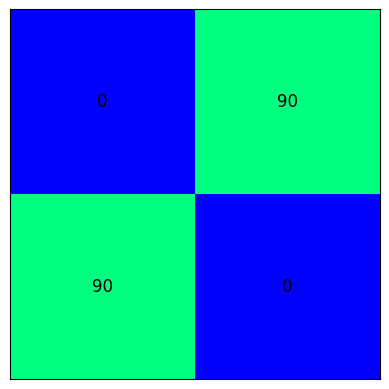

In [8]:
# modes = get_hypersphere_modes(dim=10, num_modes=2, radius=10, key=jax.random.PRNGKey(0))
modes = target_modes

dot_product_matrix = modes @ modes.T

norms = jnp.linalg.norm(modes, axis=1)
norm_product_matrix = norms[:, jnp.newaxis] * norms[jnp.newaxis, :]
cosine_theta = dot_product_matrix / norm_product_matrix
cosine_theta_clipped = jnp.clip(cosine_theta, -1.0, 1.0)
angle_matrix = jnp.rad2deg(jnp.arccos(cosine_theta_clipped))
fig, ax = plt.subplots(1, 1)
ax.imshow(angle_matrix, cmap='winter')
for i in range(angle_matrix.shape[0]):  # i is the row index (y-coordinate)
    for j in range(angle_matrix.shape[1]):  # j is the column index (x-coordinate)
            # Get the value
            value = angle_matrix[i, j]
            text_color = 'black'
            ax.text(j, i, 
                    f'{value:.0f}',  # Format the number to 2 decimal places
                    ha='center',     # Horizontal alignment (center the text)
                    va='center',     # Vertical alignment (center the text)
                    color=text_color,
                    fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Plot samples from learned distribution

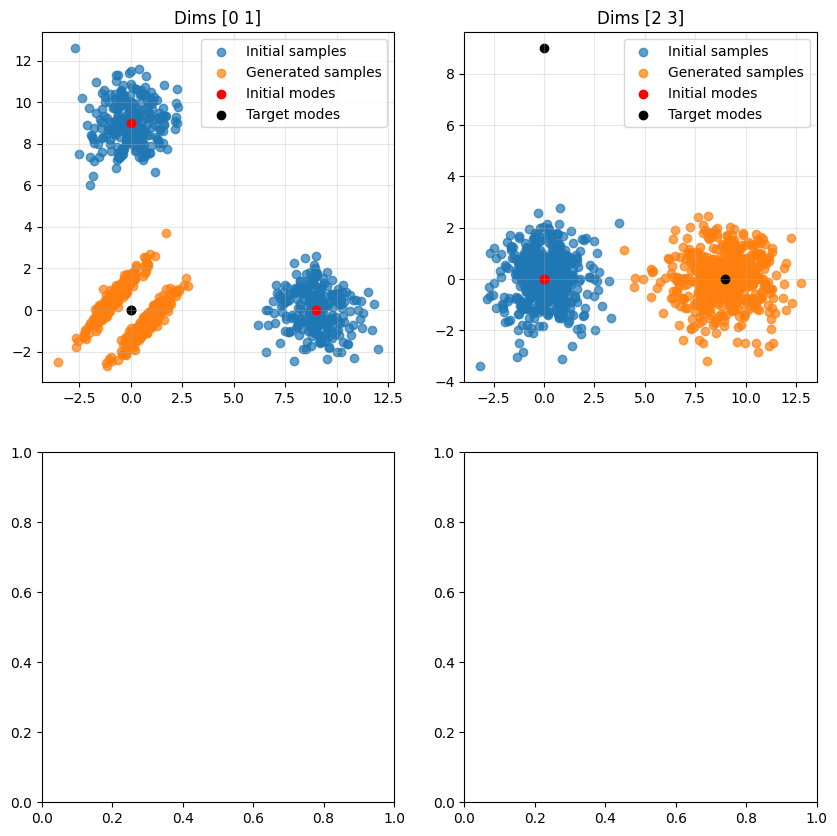

In [42]:
# Get initial samples
key = jax.random.PRNGKey(0)
initial_samples = initial_sampler(key)

# Push samples through model
ts = [0, 1, 0.01]
t_eval = -1
model = lambda t, x: loaded_weights[t_eval] @ x
generated_xs = jax.vmap(lambda x: eqx.filter_jit(phi)(model, x, ts))(initial_samples)
# generated_xs, z_ins, z_outs = jax.vmap(loaded_model)(initial_samples)
# transformed_mean = estimate_evolved_means(key, component_idxs=jnp.array([0, 1]), means=initial_modes, 
#                                             covs=jnp.tile(jnp.identity(dim), (2, 1, 1)), 
#                                             W=loaded_weights[t_eval], num_samples=1000)

# Plot samples
num_plots = num_initial_modes
fig, axes = plt.subplots(num_plots//2 + 1, 2, figsize=(10, 5*(num_plots//2+1)))
dims_to_plot = jnp.arange(dim).reshape((-1, 2))
# dims_to_plot = jnp.array([[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]])
for i in range(num_plots):
    axes[i//2, i%2].scatter(initial_samples[:, dims_to_plot[i, 0]], initial_samples[:, dims_to_plot[i, 1]], label="Initial samples", alpha=0.7)
    axes[i//2, i%2].scatter(generated_xs[:, dims_to_plot[i, 0]], generated_xs[:, dims_to_plot[i, 1]], label="Generated samples", alpha=0.7)
    axes[i//2, i%2].scatter(initial_modes[:, dims_to_plot[i, 0]], initial_modes[:, dims_to_plot[i, 1]], c='r', label='Initial modes')
    axes[i//2, i%2].scatter(target_modes[:, dims_to_plot[i, 0]], target_modes[:, dims_to_plot[i, 1]], c='k', label='Target modes')
    # ax.scatter(transformed_mean[0, dims_to_plot[i, 0]], transformed_mean[0, dims_to_plot[i, 1]], c='g', label='Transformed mean 1')
    # ax.scatter(transformed_mean[1, dims_to_plot[i, 0]], transformed_mean[1, dims_to_plot[i, 1]], c='y', label='Transformed mean 2')
    axes[i//2, i%2].set_title(f'Dims {dims_to_plot[i]}')
    axes[i//2, i%2].grid(True, alpha=0.3)
    axes[i//2, i%2].legend()
# ax1.set_title('Initial mode plane')
# ax2.set_title('Target mode plane')
# for ax in (ax1, ax2):
#     ax.set_aspect('equal')
plt.show()
# fig.savefig('1collapse_model_3modes.pdf', format='pdf')

#### Summary statistics

##### Old

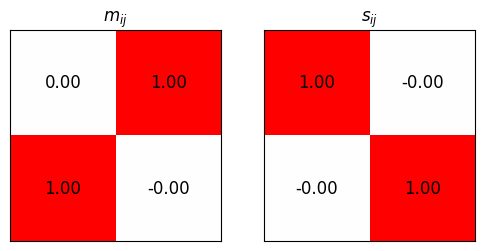

In [174]:
# print(initial_modes.shape)
M, S, _, _ = get_linear_summary_stats(loaded_weights[t_eval], initial_modes, target_modes, radius=initial_radius)
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
vminmax_M = jnp.max(jnp.abs(M))
vminmax_S = jnp.max(jnp.abs(S))
im1 = axes[0].imshow(M, cmap='bwr', vmin=-vminmax_M, vmax=vminmax_M)
im2 = axes[1].imshow(S, cmap='bwr', vmin=-vminmax_S, vmax=vminmax_S)
axes[0].set_title(r'$m_{ij}$')
axes[1].set_title(r'$s_{ij}$')
# fig.colorbar(im1)
# fig.colorbar(im2)
for ax in (axes[0], axes[1]):
    ax.set_xticks([])
    ax.set_yticks([])
for i in range(M.shape[0]):  # i is the row index (y-coordinate)
    for j in range(M.shape[1]):  # j is the column index (x-coordinate)
        # Get the value
        value = M[i, j]
        text_color = 'black'
        axes[0].text(j, i, 
            f'{value:.2f}',  # Format the number to 2 decimal places
            ha='center',     # Horizontal alignment (center the text)
            va='center',     # Vertical alignment (center the text)
            color=text_color,
            fontsize=12)
        
for i in range(S.shape[0]):  # i is the row index (y-coordinate)
    for j in range(S.shape[1]):  # j is the column index (x-coordinate)
        # Get the value
        value = S[i, j]
        text_color = 'black'
        axes[1].text(j, i, 
            f'{value:.2f}',  # Format the number to 2 decimal places
            ha='center',     # Horizontal alignment (center the text)
            va='center',     # Vertical alignment (center the text)
            color=text_color,
            fontsize=12)

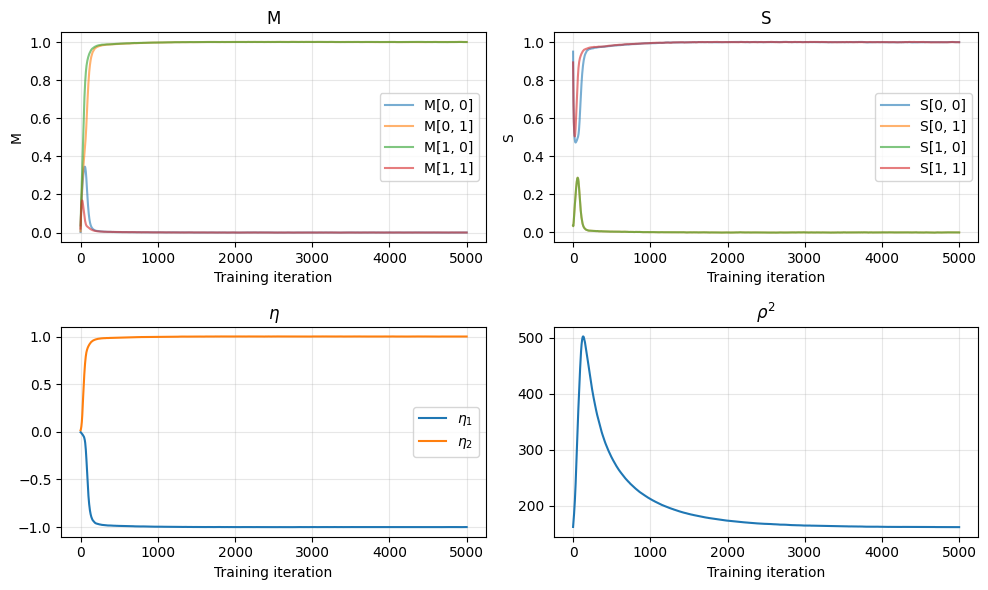

In [175]:
Ms, Ss, etas, rhos = jax.vmap(get_linear_summary_stats, in_axes=(0, None, None, None))(loaded_weights, initial_modes, target_modes, initial_radius)
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
t_lim = 5000

# Plot M
for i in range(4):
    axes[0, 0].plot(Ms[:t_lim, i//num_initial_modes, i%num_initial_modes], label=f'M[{i//num_initial_modes}, {i%num_initial_modes}]', alpha=0.6)

# Plot S
for i in range(4):
    axes[0, 1].plot(Ss[:t_lim, i//num_initial_modes, i%num_initial_modes], label=f'S[{i//num_initial_modes}, {i%num_initial_modes}]', alpha=0.6)

# Plot etas
axes[1, 0].plot(etas[:, 0], label=r'$\eta_1$')
axes[1, 0].plot(etas[:, 1], label=r'$\eta_2$')

# Plots rhos
axes[1, 1].plot(rhos)

# Labels
axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[0, 0].set_title('M')
axes[0, 1].set_title('S')
axes[1, 0].set_title(r'$\eta$')
axes[1, 1].set_title(r'$\rho^2$')
for ax in (axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]):
    ax.set_xlabel('Training iteration')
    ax.grid(True, alpha=0.3)
axes[0, 0].set_ylabel('M')
axes[0, 1].set_ylabel('S')


plt.tight_layout()
plt.show()
# fig.savefig('summary_stats_collapse.pdf', format='pdf')

##### Minimum

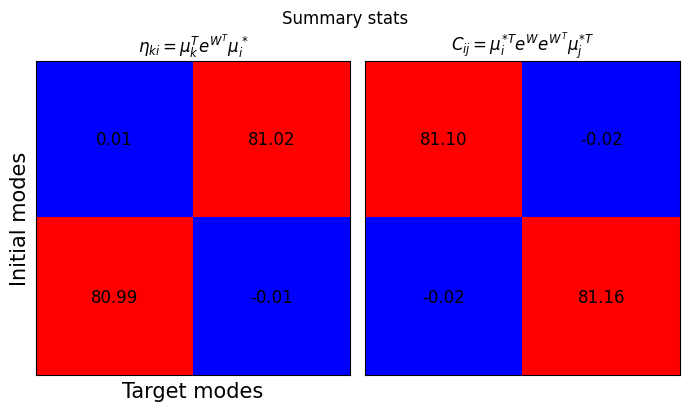

In [ ]:
time_derivs = False
Us, Vs, etas, Cs = jax.vmap(get_minimum_summary_stats, in_axes=(0, None, None, None))(loaded_weights, initial_modes, target_modes)
t_eval = -1
text = True
# to_plot = etas[t_eval]
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(etas[t_eval], cmap='bwr')
ax[0].set_title(r'$\eta_{ki}=\mu_k^T e^{W^T} \mu_i^*$')
ax[0].set_xlabel('Target modes', size=15)
ax[0].set_ylabel('Initial modes', size=15)
ax[1].imshow(Cs[t_eval], cmap='bwr')
ax[1].set_title(r'$C_{ij}=\mu_i^{*T}e^W e^{W^T}\mu_j^{*T}$')
for k, to_plot in enumerate([etas[t_eval], Cs[t_eval]]):
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    if text:
        for i in range(to_plot.shape[0]):  # i is the row index (y-coordinate)
            for j in range(to_plot.shape[1]):  # j is the column index (x-coordinate)
                # Get the value
                value = to_plot[i, j]
                text_color = 'black'
                ax[k].text(j, i, 
                    f'{value:.2f}',  # Format the number to 2 decimal places
                    ha='center',     # Horizontal alignment (center the text)
                    va='center',     # Vertical alignment (center the text)
                    color=text_color,
                    fontsize=12)
fig.suptitle('Summary stats')
fig.tight_layout()
# fig.savefig('collapse_summary_stats.png')

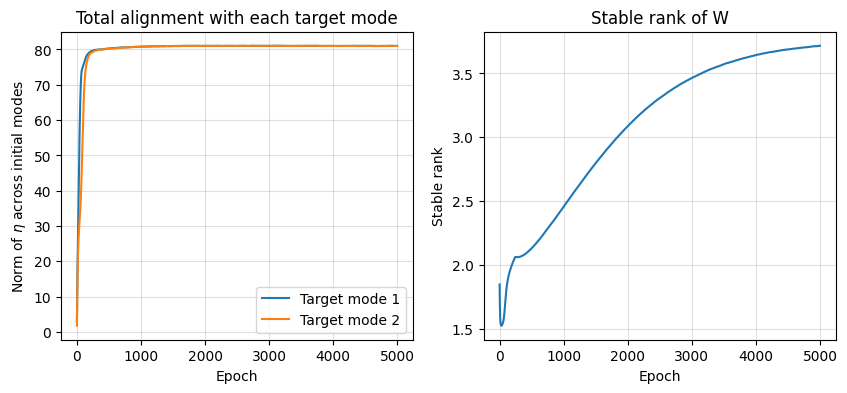

In [53]:
t_eval = 5000
target_alignment_evolution = jax.vmap(lambda eta: jnp.linalg.norm(eta, axis=0))(etas[:t_eval])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
labels = [f'Target mode {i+1}' for i in range(num_initial_modes)]
ax[0].plot(target_alignment_evolution, label=labels)
ax[0].set_title('Total alignment with each target mode')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel(r'Norm of $\eta$ across initial modes')
ax[0].grid(True, alpha=0.4)
ax[0].legend()

ax[1].plot(loaded_ranks[:t_eval])
ax[1].set_title('Stable rank of W')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Stable rank')
ax[1].grid(True, alpha=0.4)
plt.show()
# fig.savefig('perfect_eta_evolution.png')

In [21]:
1- (target_alignment_evolution[-1] < 2)

Array([0, 1, 1], dtype=int32, weak_type=True)

#### Make gif of solutions in time

In [16]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import equinox as eqx

# --- CONFIGURATION ---
SAVE_FILENAME = "cnf_linear_flow_collapse_2.gif"
STRIDE = 2    # Plot every 10th iteration (adjust based on total iterations)
FPS = 15   # Frames per second

# --- 1. OPTIMIZED SOLVER FUNCTIONS ---

def linear_vector_field(t, y, W):
    """
    Field definition: dz/dt = W @ z
    Note: 'W' is passed as the 'args' from the solver.
    """
    return W @ y

@jax.jit
def compute_batch_flow(W, x_batch, ts):
    """
    JIT-compiled step that solves the flow for a whole batch.
    
    Args:
        W: Weight matrix (dim, dim)
        x_batch: Batch of samples (num_samples, dim)
        ts: Time steps [t0, t1, dt]
    """
    
    # We define a single-sample solver, then vmap it over the batch
    def solve_single(x):
        term = diffrax.ODETerm(linear_vector_field)
        solver = diffrax.Tsit5()
        
        # We pass 'W' as the args to the solver
        sol = diffrax.diffeqsolve(
            term, 
            solver, 
            t0=ts[0], 
            t1=ts[1], 
            dt0=ts[2], 
            y0=x, 
            args=W,  # Pass the weight matrix here
            max_steps=4096 # Safety buffer
        )
        return sol.ys[0] # Return the final state at t1

    return jax.vmap(solve_single)(x_batch)

# --- 2. SETUP DATA & PLOTTING BOUNDS ---

# Assuming variables exist from your training session:
# loaded_weights: (num_iterations, dim, dim)
# initial_samples: (num_samples, dim)
# initial_modes: (k, dim)
# target_modes: (k, dim)
# ts: [0, 1, 0.01]
lim=400
num_iterations = len(loaded_weights[:lim])
dim = loaded_weights[0].shape[0]

# Calculate fixed axis bounds based on ALL data to prevent camera jitter
all_data = jnp.concatenate([initial_samples, initial_modes, target_modes], axis=0)
# Add a 10% buffer around the data
global_min = jnp.min(all_data) - 1.0
global_max = jnp.max(all_data) + 1.0

# --- 3. INITIALIZE FIGURE ---

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1, ax2]

# Dimensions to visualize (e.g. dim 0 vs 1, and dim 2 vs 3)
# Adjust this if your data is only 2D (just ignore the second plot or repeat)
dims_to_plot = jnp.array([[0, 1], [2, 3]])

# Lists to store the plot objects we need to update
scatters_generated = []
scatters_modes_curr = []

for i, ax in enumerate(axes):
    if 2*i + 1 >= dim: continue # Skip if dimension doesn't exist

    d1, d2 = dims_to_plot[i]
    
    # A. Static Background (Initial Noise & Targets)
    ax.scatter(initial_samples[:, d1], initial_samples[:, d2], 
               label="Initial Noise", alpha=0.1, color='gray', s=10)
    
    ax.scatter(target_modes[:, d1], target_modes[:, d2], 
               c='k', marker='x', s=100, label='Target Modes', zorder=10)

    # B. Dynamic Objects (Flow Output & Transformed Modes)
    # We initialize them with empty data []; they get filled in update()
    sc_gen = ax.scatter([], [], c='tab:blue', alpha=0.6, s=15, label='Flow Output')
    scatters_generated.append(sc_gen)
    
    sc_modes = ax.scatter([], [], c='tab:red', s=100, label='Learned Modes', zorder=9)
    scatters_modes_curr.append(sc_modes)
    
    # C. Formatting
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Dimensions {d1} vs {d2}')
    if i == 0: ax.legend(loc='upper right') # Only legend on first plot

suptitle = fig.suptitle(f'Iteration: 0', fontsize=16)

# --- 4. ANIMATION LOOP ---

def update(frame_idx):
    # Convert frame index to training iteration index
    iter_idx = frame_idx * STRIDE
    
    # Get weights for this specific iteration
    W = loaded_weights[iter_idx]
    
    # --- FAST SOLVE ---
    # Since compute_batch_flow is JIT-compiled, this runs incredibly fast
    # We pass the weights 'W' as data
    current_generated = compute_batch_flow(W, initial_samples, jnp.array(ts))
    current_modes = compute_batch_flow(W, initial_modes, jnp.array(ts))
    
    # Update Plot Positions
    for i, ax in enumerate(axes):
        if i >= len(scatters_generated): continue
        d1, d2 = dims_to_plot[i]
        
        # Update Flow Output (Blue dots)
        data_gen = jnp.stack([current_generated[:, d1], current_generated[:, d2]], axis=1)
        scatters_generated[i].set_offsets(data_gen)
        
        # Update Modes (Red dots)
        data_modes = jnp.stack([current_modes[:, d1], current_modes[:, d2]], axis=1)
        scatters_modes_curr[i].set_offsets(data_modes)

    suptitle.set_text(f'Training Iteration: {iter_idx}')
    
    # Return list of artists that changed
    return scatters_generated + scatters_modes_curr + [suptitle]

# --- 5. GENERATE & SAVE ---

print(f"Generating GIF ({num_iterations // STRIDE} frames)...")

anim = animation.FuncAnimation(
    fig, 
    update, 
    frames=range(num_iterations // STRIDE), 
    interval=1000 / FPS, 
    blit=True
)

anim.save(SAVE_FILENAME, writer='pillow')
print(f"Done! Saved to {SAVE_FILENAME}")
plt.close()

Generating GIF (200 frames)...
Done! Saved to cnf_linear_flow_collapse_2.gif


#### Plot distribution analysis

In [10]:
def plot_analysis_2modes(model, key, initial_distribution_sampler, target_distribution_sampler, 
                  initial_distribution_pdf, target_distribution_pdf, target_modes, target_radius, 
                  losses, weight_ranks, title=None, metrics=True):
    
    # Create master figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))

    # Plot parallel distance from mode line
    _, _, _ = plot_distribution_histogram_parallel(model, initial_distribution_sampler, key,
                                                              target_modes[0], target_modes[1], num_bins=70,
                                                              figsize=(6, 5), ax=axes[0, 0])
    
    # Plot perpendicular distance from mode line
    _, _, _ = plot_distribution_histogram_perpendicular(model, initial_distribution_sampler, key, 
                                                        target_modes[0], target_modes[1], num_bins=70,
                                                        figsize=(6, 5), ax=axes[0, 1])
    
    # Plot losses
    axes[1, 0].plot(losses)
    axes[1, 0].set_ylabel('Loss')

    # Plot rank of weights
    if len(weight_ranks.shape) > 1:
        for i in range(weight_ranks.shape[1]):
            axes[1, 1].plot(weight_ranks[:, i], label=f'W{i+1}')
        axes[1, 1].legend()
    else: 
        axes[1, 1].plot(weight_ranks)

    axes[1, 1].set_ylabel('Stable rank')
    
    for ax in [axes[1, 0], axes[1, 1]]:
        ax.grid()
        ax.set_xlabel('Training iterations')
    
    # Calculate mode alignment
    w_plus, _, _, _, s = w_mu_plus_minus(model, initial_distribution_sampler, key, target_modes[0], target_modes[1], radius=target_radius)

    # Calculate KL divergence between learned and target distribution
    target_samples = target_distribution_sampler(key)
    ts = [1, 0, -0.01]
    kl = kl_divergence_target_vs_learned(target_samples, target_distribution_pdf, initial_distribution_pdf, model, ts, key, approx=True)

    if metrics:
        # Add metrics as text
        x = weight_ranks.shape[0] / 2
        y= (jnp.max(weight_ranks) - jnp.min(weight_ranks)) / 2 + jnp.min(weight_ranks)

        axes[1, 1].text(x, y, f'w_plus: {w_plus:.4f}\n Mode alignment: {s:.4f}\n KL(target||learned): {kl:.4f}', 
            fontsize=12, 
            color='black',
            weight='bold',
            ha='center',  # horizontal alignment
            va='center',     # vertical alignment
            bbox=dict(boxstyle='round', alpha=0.7))
    
    # Set title
    fig.suptitle(title)
    fig.tight_layout()
    
    return fig, axes

In [11]:
def plot_analysis_Nmodes(model, key, initial_distribution_sampler, target_distribution_sampler, 
                  initial_distribution_pdf, target_distribution_pdf, target_modes, target_radius, 
                  losses, weight_ranks, title=None):
    
    dim = target_modes.shape[1]
    n_modes = target_modes.shape[0]
    
    if n_modes % 2 == 0:
        num_plots = n_modes//2 + 1
    else:
        num_plots = n_modes//2 + 2

    fig, axes = plt.subplots(num_plots, 2, figsize=(10, 2*n_modes))

    # Plot distances parallel and perp to each mode
    for i in range(n_modes):
        # Plot parallel distance from mode line
        _, _, _ = plot_distribution_histogram_parallel(model, initial_distribution_sampler, key,
                                                                jnp.zeros(dim), target_modes[i], num_bins=70,
                                                                figsize=(6, 5), ax=axes[i//2, i%2], midpoint_align=False)
        
        axes[i//2, i%2].set_title(f'Parallel distance mode {i+1}')
        # axes[i//2, i%2].set_title(f'Parallel distance mode ({target_modes[i, 0]:.3f}, {target_modes[i, 1]:.3f})')

        # Plot perpendicular distance from mode line
        # _, _, _ = plot_distribution_histogram_perpendicular(model, initial_distribution_sampler, key, 
        #                                                     jnp.zeros(dim), target_modes[i], num_bins=70, ax=axes[i, 1])
        # axes[i, 1].set_title(f'Perp distance mode {i+1}')


    # Plot losses
    axes[-1, 0].plot(losses)
    axes[-1, 0].set_ylabel('Loss')
    
    # Plot rank of weights
    if len(weight_ranks.shape) > 1:
        for i in range(weight_ranks.shape[1]):
            axes[-1, 1].plot(weight_ranks[:, i], label=f'W{i+1}')
        axes[-1, 1].legend()
    else: 
        axes[-1, 1].plot(weight_ranks)

    axes[-1, 1].set_ylabel('Stable rank')
    
    for ax in [axes[num_plots-1, 0], axes[num_plots-1, 1]]:
        ax.grid()
        ax.set_xlabel('Training iterations')
        
    return fig, axes

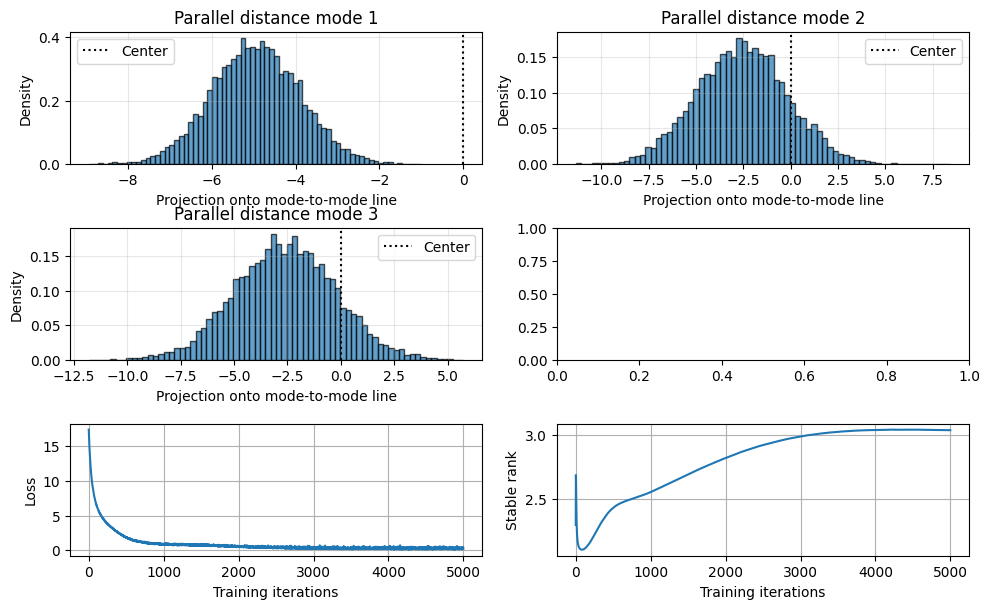

In [23]:
title = fname.split('.')[0].split("/")[-1]
# fig, axes = plot_analysis_2modes(loaded_model, key, initial_sampler, target_sampler, 
#                           initial_pdf, target_pdf, target_modes, 
#                           target_radius, loaded_losses, loaded_ranks, title=title, metrics=False)
fig, axes = plot_analysis_Nmodes(loaded_model, key, initial_sampler, target_sampler, 
                          initial_pdf, target_pdf, target_modes, 
                          target_radius, loaded_losses, loaded_ranks, title=title)
# fig.savefig('analysis_1model_0train.pdf', format='pdf')

In [20]:
dip_index = jnp.argmin(loaded_ranks[6000:])
peak_index = jnp.argmax(loaded_ranks[dip_index:]) + dip_index
print(dip_index)
print(peak_index)
# print(f'dip at {jnp.argmin(loaded_ranks)}')
# print(f'max at {jnp.argmax(loaded_ranks[:])}')
# print(f'initial peak at {jnp.argmax(loaded_ranks[10:jnp.argmin(loaded_ranks)])}')

938
9999


In [12]:
def get_compression_grad(lmbda, dim):
    initial_1 = jnp.identity(dim)[0]
    initial_2 = jnp.identity(dim)[1]
    target_1 = jnp.identity(dim)[2]
    target_2 = jnp.identity(dim)[3]

    term1 = jnp.exp(-2*lmbda) * (jnp.identity(dim) + 0.5*(jnp.outer(initial_1, initial_1) + jnp.outer(initial_2, initial_2)))
    term2 = 0.25 * jnp.exp(-lmbda) * (target_1 + target_2).reshape((-1, 1)) @ (initial_1 + initial_2).reshape((1, -1))

    return -jnp.identity(dim) + term1 - term2

dim = 4
lmbdas = jnp.linspace(0, 20, 10000)
grads = jax.vmap(get_compression_grad, in_axes=(0, None))(lmbdas, dim)
grads[-1]

Array([[-1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00, -1.000000e+00,  0.000000e+00,  0.000000e+00],
       [-5.152884e-10, -5.152884e-10, -1.000000e+00,  0.000000e+00],
       [-5.152884e-10, -5.152884e-10,  0.000000e+00, -1.000000e+00]],      dtype=float32)

#### Identify collapse radius

##### Varying dimension

In [8]:
# Define model
dims = [15, 20, 25, 30, 40, 50, 100]
epochs = 10000
tol = 0.1

# Define radii
num_repeats = 10
radii = jnp.repeat(jnp.arange(40, 91, step=2)/10, num_repeats)
# radii = jnp.repeat(jnp.arange(3, 11), num_repeats)
key = jax.random.PRNGKey(0)

ys = []
y1s = []
y2s = []

for dim in dims:
    folder_path = Path(f'reverse_KL_experiments/collapse_radius_models_random_orthogonal/{dim}D') # Replace with your actual path
    path_list = [p for p in folder_path.iterdir() if p.is_file()]

    args = (jax.random.PRNGKey(0), dim, 0.1)

    w_pluses = []

    for i, fname in enumerate(path_list):
        key, current_key = jax.random.split(key)

        current_model, _, _, _, _, _ = load_model(fname, dim, 'linear', args, epochs, weights_ranks_grads=False)

        _, target_modes, initial_sampler, _, _, _ = define_distributions(dim, radii[i], radii[i], 2, 2, 'random_hypersphere_orthogonal', 
                                                                        10000, key=jax.random.PRNGKey(0), eps_deg=2)
        
        w_plus, _, _, _, _ = w_mu_plus_minus(current_model, initial_sampler, current_key, target_modes[0], target_modes[1], radii[i])

        w_pluses.append(w_plus)

    w_pluses = jnp.array(w_pluses).reshape((-1, num_repeats))
    # print(w_pluses.shape)
    has_collapsed = jnp.int32(jnp.abs(w_pluses - 0.5) > tol)
    indices = jnp.argmax(has_collapsed, axis=0)
    collapse_radii = radii[::10][indices[jnp.sum(has_collapsed, axis=0) != 0]] # If no collapse observed, ignore seed
    print(f'R_c for {dim}D: {collapse_radii}')
    ys.append(jnp.mean(collapse_radii))
    y1s.append(jnp.min(collapse_radii))
    y2s.append(jnp.max(collapse_radii))

R_c for 15D: [4.8 5.2 5.2 5.4 4.8 5.  5.4 4.8 5.2 5.2]
R_c for 20D: [5.2 5.  5.4 5.2 5.4 5.  5.4 5.2 5.2 5.4]
R_c for 25D: [5.  5.2 5.  5.  5.  5.2 5.2 5.  5.2 5.2]
R_c for 30D: [4.8 4.8 4.8 4.8 4.6 4.8 4.6 4.8 4.8 4.6]
R_c for 40D: [4.8 4.8 4.6 4.8 4.6 4.8 4.6 4.8 4.8 4.8]
R_c for 50D: [4.8 5.  4.6 5.  5.  4.8 5.  5.  4.8 5. ]
R_c for 100D: [5.  4.8 5.  4.8 4.8 4.8 4.8 4.8 4.8 4.8]


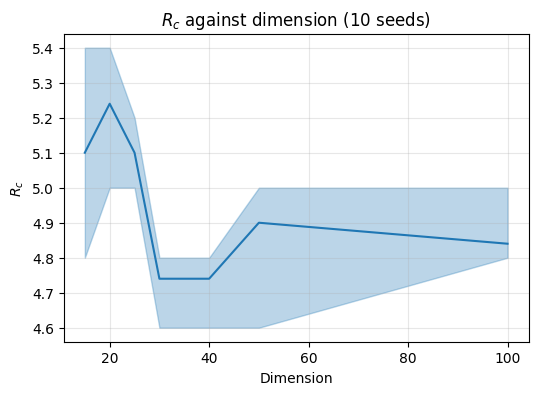

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dims, ys)
ax.fill_between(dims, y1s, y2s, color='C0', alpha=0.3)
ax.grid(True, alpha=0.3)
ax.set_xlabel('Dimension')
ax.set_ylabel(r'$R_c$')
ax.set_title(r'$R_c$ against dimension (10 seeds)')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()
# fig.savefig('collapse_radii_over_seeds_random_orthogonal.pdf', format='pdf')

In [97]:
tol = 0.1
has_collapsed = jnp.int32(jnp.abs(w_pluses - 0.5) > tol)
indices = jnp.argmax(has_collapsed, axis=0)
collapse_radii_4D = radii[::5][indices]
print(f'Collapse radii for 4D: {collapse_radii_4D}')

Collapse radii for 4D: [4.8 4.9 4.7 5.2 4.9]


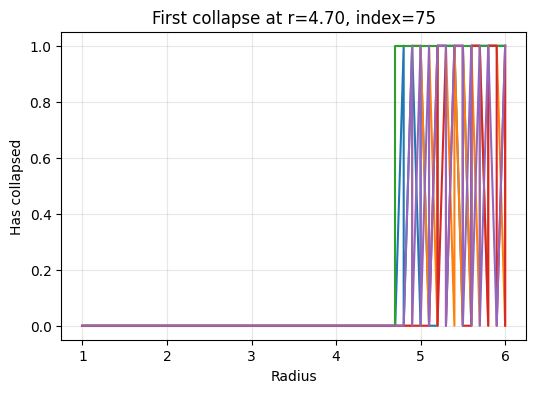

In [53]:
collapsed = jnp.sum(jnp.abs(w_pluses - 0.5) > 0.1, axis=1) > 0
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(radii[::5], has_collapsed)
ax.set_xlabel('Radius')
ax.set_ylabel('Has collapsed')
ax.grid(True, alpha=0.3)
ax.set_title(f'First collapse at r={radii[::5][jnp.argmax(collapsed[1:])+1]:.2f}, index={jnp.argmax(collapsed[1:])+1}')
plt.show()

##### Varying seed analytic

In [32]:
# Define model
# sample_nums = [1, 5, 10, 18, 20, 25]
# epochs = [20000, 10000, 5000, 10000, 10000, 10000]
sample_nums = [1, 5, 7, 10, 15, 20]
epochs = [10000, 10000, 10000, 20000, 10000, 10000]
tol = 0.1

folder_path = Path('reverse_KL_experiments/analytic_grads/varying_seeds_and_samples/seed2')

ys = []
y1s = []
y2s = []
dim = 10
radius = 9
path_list = [p for p in folder_path.iterdir() if p.is_file()]
args = (jax.random.PRNGKey(0), dim, 0.1)

w_pluses = []

for i, fname in enumerate(path_list):
    print(i)
    key, current_key = jax.random.split(key)
    fname = f'reverse_KL_experiments/analytic_grads/varying_seeds_and_samples/seed2/Linear_10D_9radius_2modes_orthogonal_001init_analytic_{sample_nums[i]}000sample_0modelseed_22239trainseed.eqx'
    current_model, _, _, _, _, _ = load_model(fname, dim, 'linear', args, epochs[i], weights_ranks_grads=True)

    _, target_modes, initial_sampler, _, _, _ = define_distributions(dim, radius, radius, 2, 2, 'orthogonal', 
                                                                    10000, key=jax.random.PRNGKey(0), eps_deg=2)
    
    w_plus, _, _, _, _ = w_mu_plus_minus(current_model, initial_sampler, current_key, target_modes[0], target_modes[1], radius)

    w_pluses.append(w_plus)

w_pluses = jnp.array(w_pluses)

has_collapsed = jnp.int32(jnp.abs(w_pluses - 0.5) > tol)
# indices = jnp.argmax(has_collapsed, axis=0)
# collapse_radii = radii[::10][indices[jnp.sum(has_collapsed, axis=0) != 0]] # If no collapse observed, ignore seed
# print(f'R_c for {dim}D: {collapse_radii}')
# ys.append(jnp.mean(collapse_radii))
# y1s.append(jnp.min(collapse_radii))
# y2s.append(jnp.max(collapse_radii))

0
1
2
3
4
5


##### Varying num modes

In [104]:


num_collapsed_to = []

dims = [6, 8]
num_modes = [3, 4]

radius = 10



for j in range(len(dims)):
    num_collapsed_to_per_num_modes = []

    args = (jax.random.PRNGKey(0), dims[j], 0.1)
    folder_path = Path(f'reverse_KL_experiments/analytic_grads/varying_seed/{num_modes[j]}modes')
    path_list = [p for p in folder_path.iterdir() if p.is_file()]
    for i, fname in enumerate(path_list):
        key, current_key = jax.random.split(key)
        current_model, _, loaded_weights, _, _, _ = load_model(fname, dims[j], 'linear', args, 5000, weights=True, ranks_grads=False)
        
        initial_modes, target_modes, _, _, _, _ = define_distributions(dims[j], radius, radius, num_modes[j], num_modes[j], 'orthogonal', 
                                                                        10000, key=jax.random.PRNGKey(0), eps_deg=2)
        
        _, _, eta_final, _ = get_minimum_summary_stats(loaded_weights[-1], initial_modes, target_modes)

        normed_eta = jnp.linalg.norm(eta_final, axis=0)

        current_num_collapsed_to = jnp.sum(1 - (normed_eta < 2))
        num_collapsed_to_per_num_modes.append(current_num_collapsed_to)
    num_collapsed_to_per_num_modes = jnp.array(num_collapsed_to_per_num_modes)
    num_collapsed_to.append(num_collapsed_to_per_num_modes)
num_collapsed_to = jnp.array(num_collapsed_to)



In [105]:
num_collapsed_to

Array([[2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
        2, 2, 1, 2, 1, 3, 3, 2],
       [1, 2, 2, 3, 2, 3, 3, 3, 2, 1, 2, 3, 1, 1, 2, 2, 2, 3, 3, 1, 2, 4,
        1, 2, 3, 2, 2, 2, 2, 2]], dtype=int32)

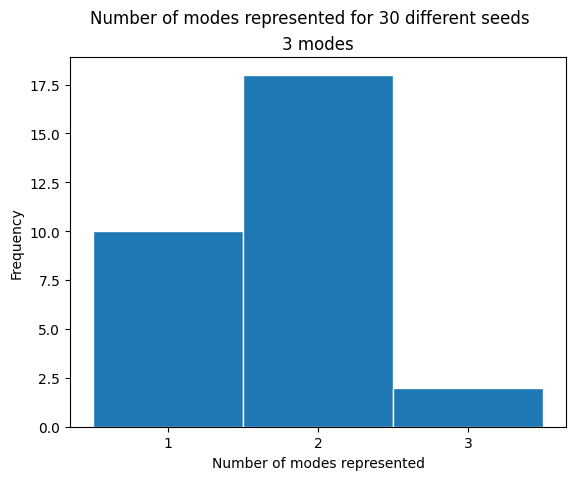

In [ ]:
fig, ax = plt.subplots(1, num_collapsed_to.shape[0])
bins = jnp.arange(num_collapsed_to.min(), num_collapsed_to.max() + 2) - 0.5
counts, edges, patches = plt.hist(num_collapsed_to, bins=bins, edgecolor='white')
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.set_xticks(bin_centers)
fig.suptitle(f'Number of modes represented for {len(path_list)} different seeds')
ax.set_title('3 modes')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of modes represented')
plt.show()


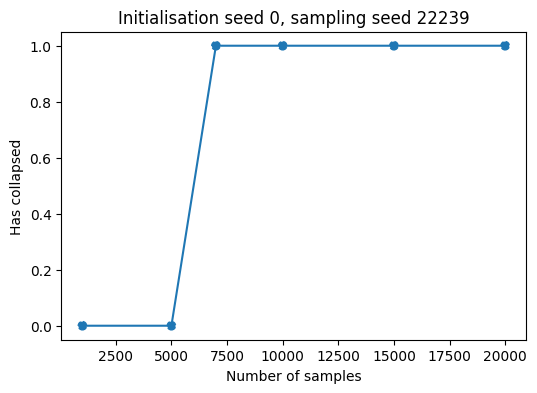

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(jnp.array(sample_nums)*1000, has_collapsed, marker='o', ls='--')
ax.plot(jnp.array(sample_nums)*1000, has_collapsed, ls='-')
ax.set_xlabel('Number of samples')
ax.set_ylabel('Has collapsed')
ax.set_title('Initialisation seed 0, sampling seed 22239')
plt.show()
# fig.savefig('has_collapsed_seed1.pdf', format='pdf')

#### Analysing gradients and eigvals at fixed time points

In [13]:
def plot_weights_eigvals(t, text=True, figsize=(6, 6)):
        fig1 = plt.figure(figsize=figsize)

        ax1 = fig1.add_subplot(121)
        vminmax = jnp.max(jnp.abs(loaded_weights[t]))
        im1 = ax1.imshow(loaded_weights[t], cmap='bwr', vmin=-vminmax, vmax=vminmax)
        fig1.colorbar(im1)
        ax1.set_title(r'$W$')
        if text:
                for i in range(loaded_weights[t].shape[0]):  # i is the row index (y-coordinate)
                        for j in range(loaded_weights[t].shape[1]):  # j is the column index (x-coordinate)
                                # Get the value
                                value = loaded_weights[t, i, j]
                                text_color = 'black'
                                ax1.text(j, i, 
                                        f'{value:.2f}',  # Format the number to 2 decimal places
                                        ha='center',     # Horizontal alignment (center the text)
                                        va='center',     # Vertical alignment (center the text)
                                        color=text_color,
                                        fontsize=12)
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax2 = fig1.add_subplot(122)
        eigvals, eigvecs = jnp.linalg.eig(loaded_weights[t])
        ax2.scatter(jnp.real(eigvals), jnp.imag(eigvals))
        maxi = jnp.max(jnp.abs(jnp.array([jnp.real(eigvals), jnp.imag(eigvals)])))
        maxi = maxi + 0.05*maxi
        ax2.set_ylim(-maxi, maxi)
        ax2.set_xlim(-maxi, maxi)
        ax2.set_xlabel(r'Re($\lambda$)')
        ax2.set_ylabel(r'Im($\lambda$)')
        ax2.grid()
        ax2.set_title('Eigenvalue spectrum of W')


        fig1.suptitle(f' { fname.split(".")[0].split("/")[-1] }, t={t}')
        fig1.tight_layout()


        
        return fig1

In [14]:
def plot_eigvecs(t, num_vecs=dim, cutoff_dim=dim, text=True, figsize=(6, 6)):
    # Figure for eigvals
    eigvals, eigvecs = jnp.linalg.eig(loaded_weights[t])
    fig = plt.figure(figsize=(4, 2*dim))
    for i in range(num_vecs):
        vecs = jnp.stack([jnp.real(eigvecs[:, i]), jnp.imag(eigvecs[:, i])], axis=1)
        vminmax = jnp.max(jnp.abs(vecs))
        ax = fig.add_subplot(dim//2+1, 2, i+1)
        im = ax.imshow(vecs[:cutoff_dim], cmap='bwr', vmin=-vminmax, vmax=vminmax)
        if i == 0:
            fig.colorbar(im)
        if text:
            for j in range(dim):  # i is the row index (y-coordinate)
                for k in range(2):  # j is the column index (x-coordinate)
                    # Get the value
                    value = vecs[j, k]
                    text_color = 'black'
                    ax.text(k, j, 
                            f'{value:.2f}',  # Format the number to 2 decimal places
                            ha='center',     # Horizontal alignment (center the text)
                            va='center',     # Vertical alignment (center the text)
                            color=text_color,
                            fontsize=12)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Re', 'Im'])
        ax.set_yticks(jnp.arange(cutoff_dim))
        ax.set_yticklabels([f'x{i+1}' for i in range(cutoff_dim)])
            
        ax.set_title(fr'$\lambda_{i+1}=${eigvals[i]:.3f}')
    fig.tight_layout()
    # fig.suptitle('Eigenbasis')

    return fig

In [15]:
def plot_grads(t, text=True):
    
        fig = plt.figure(figsize=(5, 5))

        analytic_grads = compute_analytic_gradient(loaded_weights[t], initial_modes, target_modes)

        ax1 = fig.add_subplot(121)
        vminmax = jnp.max(jnp.abs(analytic_grads))
        im1 = ax1.imshow(analytic_grads, cmap='PRGn', vmin=-vminmax, vmax=vminmax)
        fig.colorbar(im1)
        ax1.set_title('Analytic grads')
        if text:
                for i in range(analytic_grads.shape[0]):  # i is the row index (y-coordinate)
                        for j in range(analytic_grads.shape[1]):  # j is the column index (x-coordinate)
                                # Get the value
                                value = analytic_grads[i, j]
                                text_color = 'black'
                                ax1.text(j, i, 
                                        f'{value:.2f}',  # Format the number to 2 decimal places
                                        ha='center',     # Horizontal alignment (center the text)
                                        va='center',     # Vertical alignment (center the text)
                                        color=text_color,
                                        fontsize=12)

        ax2 = fig.add_subplot(122)
        vminmax = jnp.max(jnp.abs(loaded_grads[t]))
        im2 = ax2.imshow(loaded_grads[t], cmap='PRGn', vmin=-vminmax, vmax=vminmax)
        fig.colorbar(im2)
        ax2.set_title('Empirical grads')
        if text:
                for i in range(loaded_grads[t].shape[0]):  # i is the row index (y-coordinate)
                        for j in range(loaded_grads[t].shape[1]):  # j is the column index (x-coordinate)
                                # Get the value
                                value = loaded_grads[t, i, j]
                                text_color = 'black'
                                ax2.text(j, i, 
                                        f'{value:.2f}',  # Format the number to 2 decimal places
                                        ha='center',     # Horizontal alignment (center the text)
                                        va='center',     # Vertical alignment (center the text)
                                        color=text_color,
                                        fontsize=12)

        for ax in (ax1, ax2):
                ax.set_xticks([])
                ax.set_yticks([])

        fig.suptitle(f' { fname.split(".")[0].split("/")[-1] }, t={t}')
        fig.tight_layout()
        return fig

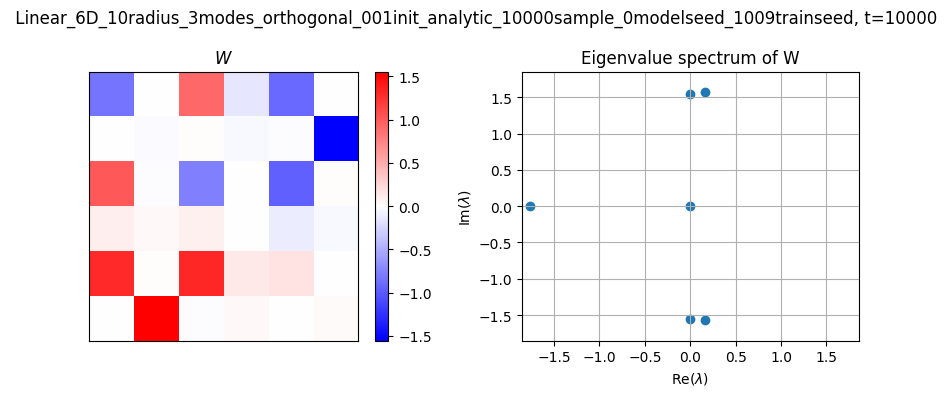

In [16]:
t = 10000
fig1 = plot_weights_eigvals(t, text=False, figsize=(8, 4))
cutoff = 0.1
# print(f'Num of non-zero weights: {jnp.sum(jnp.abs(loaded_weights[t])>cutoff)}')
# fig2 = plot_eigvecs(t, num_vecs=4, cutoff_dim=4, text=False)
# fig3 = plot_grads(t, text=False)
# fig1.savefig('weights_eigvals_1model_0train.pdf', format='pdf')
# fig2.savefig('10D_symmetric_dip_eigvecs.pdf', format='pdf')

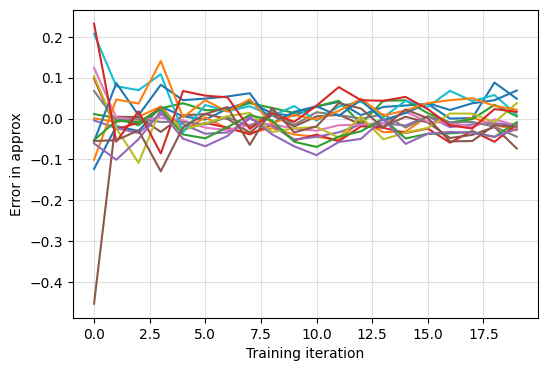

In [54]:
# Plot error in analytic gradient
num_samples = 10000
num_integral_iterations = 1000
skip_interval = 250
analytic_grads = jax.vmap(compute_gradient_orthogonal, in_axes=(0, None, None, None, None, None))(loaded_weights[::skip_interval], initial_modes, target_modes, jax.random.PRNGKey(0), num_samples, num_integral_iterations)
diff = analytic_grads - loaded_grads[::skip_interval]
# diff_m    ag = jax.vmap(lambda a, b: jnp.linalg.norm(a - b) / jnp.linalg.norm(b))(analytic_grads, loaded_grads[::skip_interval])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(diff.reshape((epochs//skip_interval, -1)))
ax.set_xlabel('Training iteration')
ax.set_ylabel('Error in approx')
ax.grid(True, alpha=0.4)

#### Schur decomposition

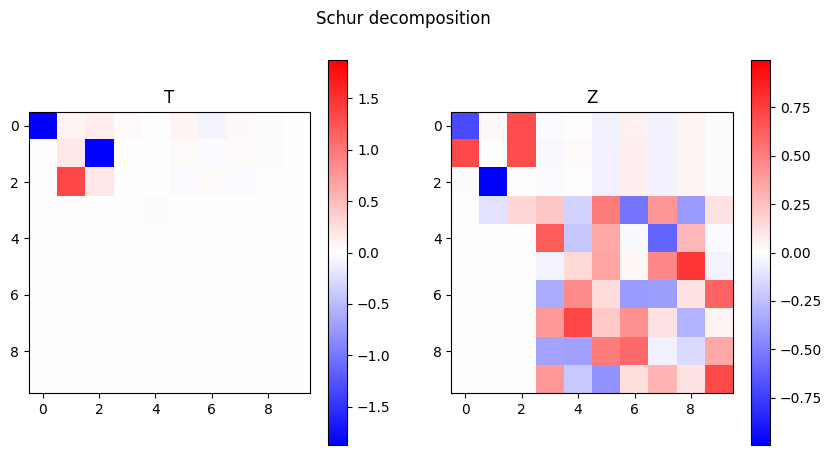

In [ ]:
import scipy
import numpy as np
t = -1
T, Z = scipy.linalg.schur(loaded_weights[t], output='real')
fig = plt.figure(figsize=(10, 5))

lim = 10
ax3 = fig.add_subplot(121)
vminmax = jnp.max(jnp.abs(T))
im3 = ax3.imshow(T[:lim, :lim], cmap='bwr', vmin=-vminmax, vmax=vminmax)
fig.colorbar(im3)
ax3.set_title('T')

ax4 = fig.add_subplot(122)
vminmax = jnp.max(jnp.abs(Z))
im4 = ax4.imshow(Z[:lim, :lim], cmap='bwr', vmin=-vminmax, vmax=vminmax)
fig.colorbar(im4)
ax4.set_title('Z')
fig.suptitle('Schur decomposition')
plt.show()
# fig.savefig('collapse_schur.png')

#### Visualising gradient flow

In [56]:
def plot_weight_flow(t_lim, dim, elev=0, azim=-90):
    fig = plt.figure(figsize=(10, 8))

    # Plot weight component evolution
    ax1 = fig.add_subplot(221)
    ws = loaded_weights[:t_lim]
    for i in range(dim**2):
        ax1.plot(ws[:, i//dim, i%dim], label=rf'$W{i//dim, i%dim}$')
    ax1.legend()
    ax1.set_title('Weight flow')
    ax1.set_xlabel('Training iteration')

    # Plot gradient component evolution
    ax2 = fig.add_subplot(222)
    grads = -loaded_grads[:t_lim]
    for i in range(dim**2):
        ax2.plot(grads[:, i//dim, i%dim], label=rf'$g{i//dim, i%dim}$')
    # ax2.plot(grads[:, 0, 1], label=r'$g_{12}$')
    # ax2.plot(grads[:, 1, 0], label=r'$g_{21}$')
    # ax2.plot(grads[:, 1, 1], label=r'$g_{22}$')
    ax2.legend()
    ax2.set_title('Gradient flow')
    ax2.set_xlabel('Training iteration')

    # Plot eigenvalue evolution 2d
    available_cmaps = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Greys', 'YlOrBr', 'PuBu']
    ax3 = fig.add_subplot(223)
    ws = loaded_weights[:t_lim]
    eigvals, eigvecs = jnp.linalg.eig(ws)
    
    for i in range(dim):
        s = ax3.scatter(jnp.real(eigvals[:, i]), jnp.imag(eigvals[:, i]), c=jnp.arange(t_lim), cmap=available_cmaps[i], label=rf'$\lambda_{i+1}$')
        cbar = fig.colorbar(s, label=rf'Time step index ($\lambda_{i+1}$)')
        cbar.set_ticks([])
    # fig.colorbar(s2, label=r'Time step index ($\lambda_2$)')
    ax3.set_title('Eigenvalue evolution (2D)')
    maxi = jnp.max(jnp.abs(jnp.array([jnp.real(eigvals), jnp.imag(eigvals)])))
    maxi = maxi + 0.05*maxi
    ax3.set_ylim(-maxi, maxi)
    ax3.set_xlim(-maxi, maxi)
    ax3.grid(True, alpha=0.4)

    # Plot eigenvalue evolution 3d
    ax4 = fig.add_subplot(224, projection='3d')
    ws = loaded_weights[:t_lim]
    eigvals, eigvecs = jnp.linalg.eig(ws)
    x_data = jnp.real(eigvals[:, 0]) 
    y_data = jnp.imag(eigvals[:, 0])
    z_data = jnp.arange(t_lim)

    for i in range(dim):
        s3d = ax4.scatter(
        jnp.real(eigvals[:, i]) , 
        jnp.imag(eigvals[:, i]), 
        z_data, 
        c=z_data,
        cmap=available_cmaps[i], 
        marker='o'
    )
        
    ax4.set_xlabel(r'$Re(\lambda)$')
    ax4.set_ylabel(r'$Im(\lambda)$')
    ax4.set_zlabel('Time')
    ax4.set_ylim(-maxi, maxi)
    ax4.set_xlim(-maxi, maxi)
    ax4.view_init(elev=elev, azim=azim)
    ax4.set_title('Eigenvalue evolution (3D)')

    for ax in (ax1, ax2):
        ax.grid()

    plt.tight_layout()

    return fig

In [57]:
def plot_gradient_breakdown(r, W, mu_star, num_samples):
    zs = sample_multimodal_gaussian(jax.random.PRNGKey(1234), means=jnp.array([jnp.identity(2)[1], -jnp.identity(2)[1]])*r,
                                    covs=jnp.tile(jnp.identity(2), (2, 1, 1)), 
                                                weights=jnp.array([0.5, 0.5]), num_samples=num_samples)
    cov_term = jnp.mean(jax.vmap(lambda w, z: jax.scipy.linalg.expm(w) @ z.reshape(-1, 1) @ z.reshape(1, -1), in_axes=(None, 0))(W, zs), axis=0)
    tanh_terms = jax.vmap(lambda w, z, mu_star: jnp.tanh(z.reshape(1, -1) @ jax.scipy.linalg.expm(w.T) @ mu_star.reshape(-1, 1)), in_axes=(None, 0, None))(W, zs, mu_star).squeeze(2)
    mean_term = jnp.mean(jax.vmap(lambda z, tanh, mu_star: tanh * mu_star.reshape(-1, 1) @ z.reshape(1, -1), in_axes=(0, 0, None))(zs, tanh_terms, mu_star), axis=0)

    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(131)
    grad = -jnp.identity(2) + cov_term - mean_term
    vminmax = jnp.max(jnp.abs(grad))
    im1 = ax1.imshow(-grad, cmap='PRGn', vmin=-vminmax, vmax=vminmax)
    plt.colorbar(im1)
    ax1.set_title('Full gradient')
    for i in range(grad.shape[0]):  # i is the row index (y-coordinate)
        for j in range(grad.shape[1]):  # j is the column index (x-coordinate)
            # Get the value
            value = -grad[i, j]
            text_color = 'black'
            ax1.text(j, i, 
                    f'{value:.2f}',  # Format the number to 2 decimal places
                    ha='center',     # Horizontal alignment (center the text)
                    va='center',     # Vertical alignment (center the text)
                    color=text_color,
                    fontsize=12)
            

    ax2 = fig.add_subplot(132)
    vminmax = jnp.max(jnp.abs(cov_term))
    im2 = ax2.imshow(-cov_term, cmap='PRGn', vmin=-vminmax, vmax=vminmax)
    plt.colorbar(im2)
    ax2.set_title('Covariance term')
    for i in range(cov_term.shape[0]):  # i is the row index (y-coordinate)
        for j in range(cov_term.shape[1]):  # j is the column index (x-coordinate)
            # Get the value
            value = -cov_term[i, j]
            text_color = 'black'
            ax2.text(j, i, 
                    f'{value:.2f}',  # Format the number to 2 decimal places
                    ha='center',     # Horizontal alignment (center the text)
                    va='center',     # Vertical alignment (center the text)
                    color=text_color,
                    fontsize=12)

    ax3 = fig.add_subplot(133)
    vminmax = jnp.max(jnp.abs(mean_term))
    im3 = ax3.imshow(mean_term, cmap='PRGn', vmin=-vminmax, vmax=vminmax)
    plt.colorbar(im3)
    ax3.set_title('Mean alignment term')
    for i in range(mean_term.shape[0]):  # i is the row index (y-coordinate)
        for j in range(mean_term.shape[1]):  # j is the column index (x-coordinate)
            # Get the value
            value = mean_term[i, j]
            text_color = 'black'
            ax3.text(j, i, 
                    f'{value:.2f}',  # Format the number to 2 decimal places
                    ha='center',     # Horizontal alignment (center the text)
                    va='center',     # Vertical alignment (center the text)
                    color=text_color,
                    fontsize=12)

    for ax in (ax1, ax2, ax3):
        ax.set_xticks([])
        ax.set_yticks([])

    return fig

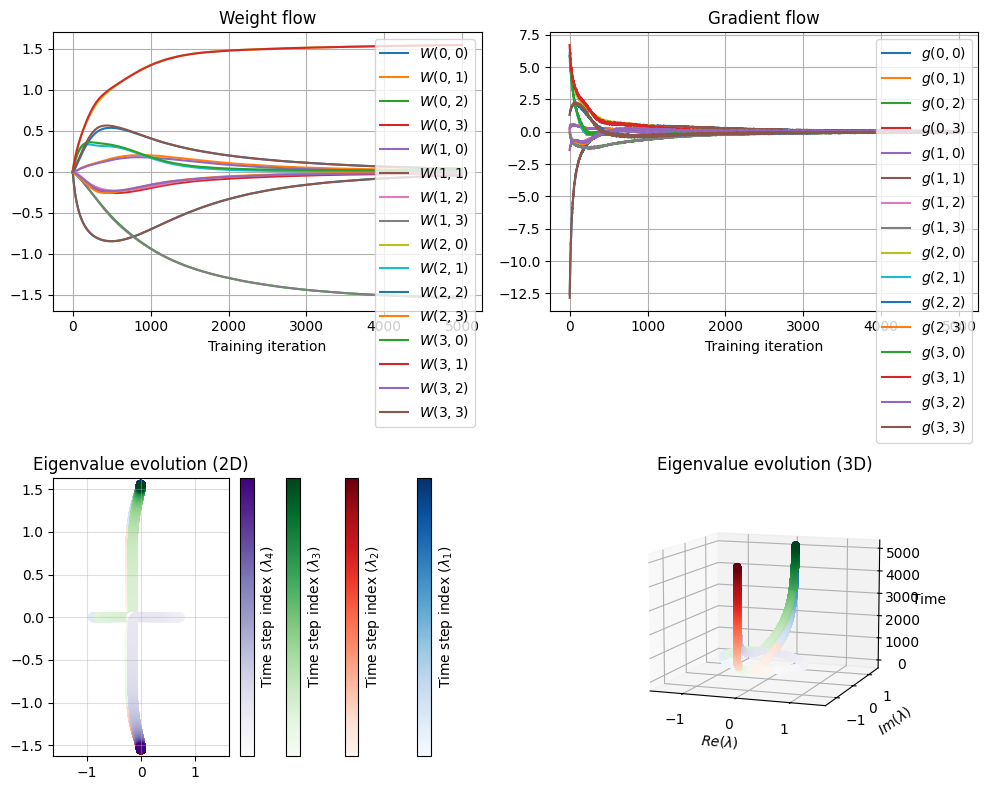

In [58]:
t_lim = 5000
fig = plot_weight_flow(t_lim=t_lim, dim=4, elev=10, azim=-70)
# fig.savefig('4D_weight_flow_4.png')

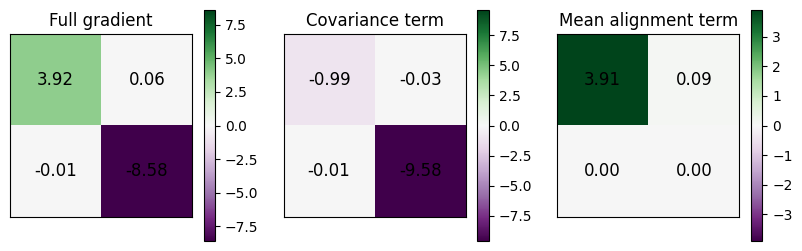

In [19]:
# W = jax.random.normal(jax.random.PRNGKey(0), shape=(2, 2)) * 0.01 # Phase 1
b = 1
W = jnp.array([[0, 0], [0, -b]]) # Phase 2
# W = loaded_weights[0]
r = 5
mu_star = jnp.array([r, 0])
num_samples = 50000

fig = plot_gradient_breakdown(r, W, mu_star, num_samples)

#### Iterate over models

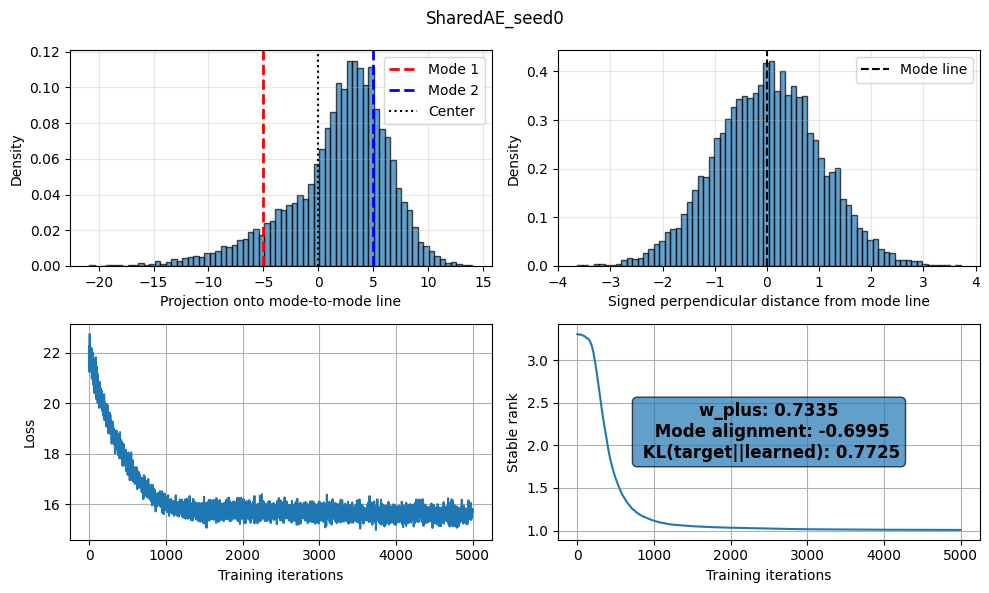

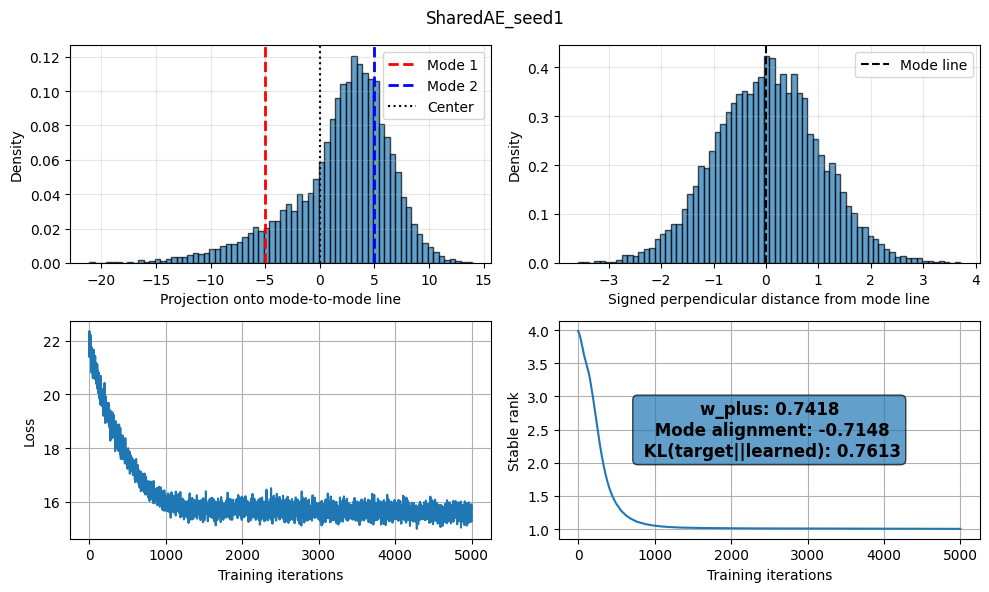

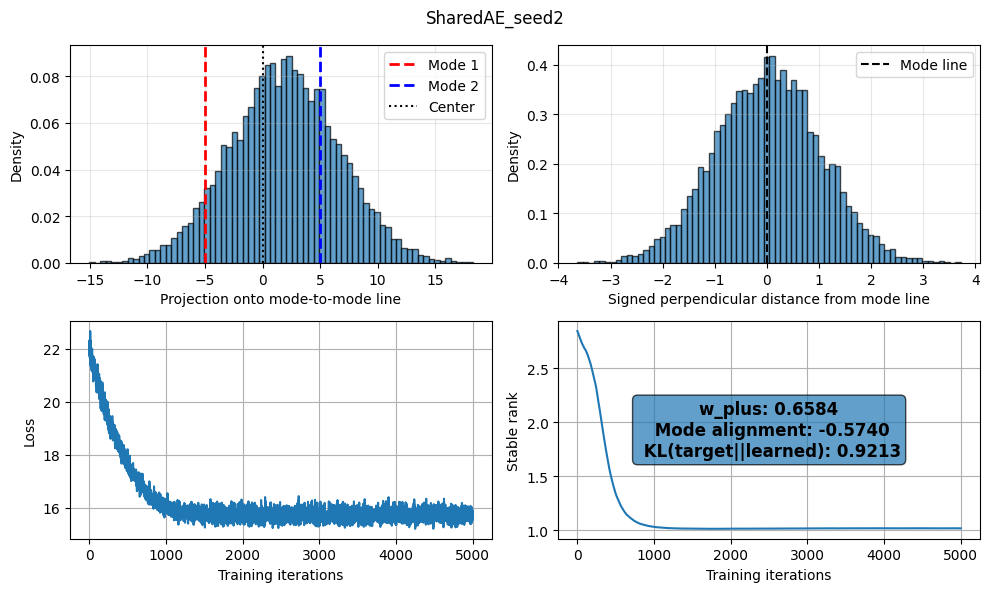

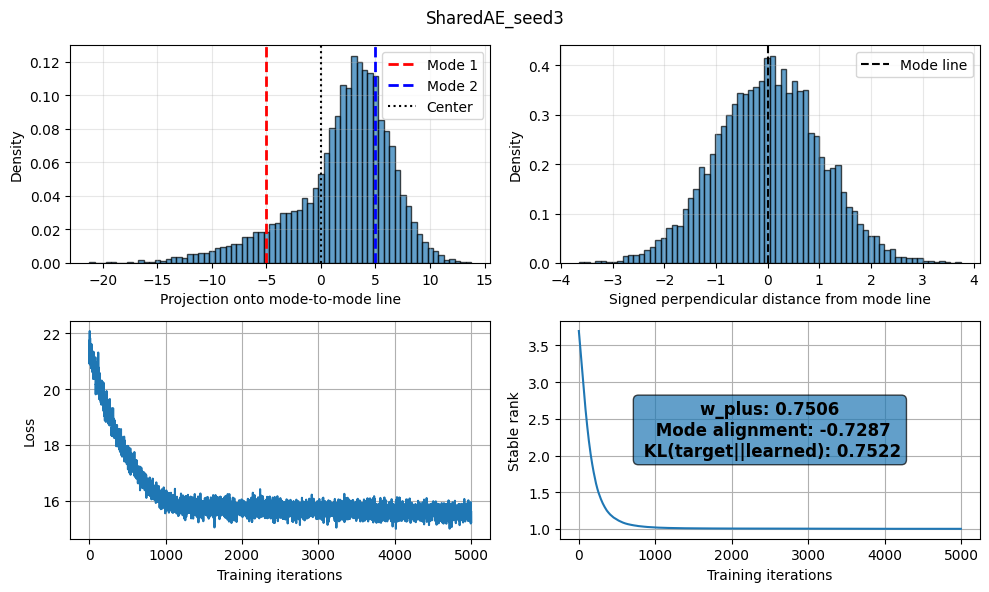

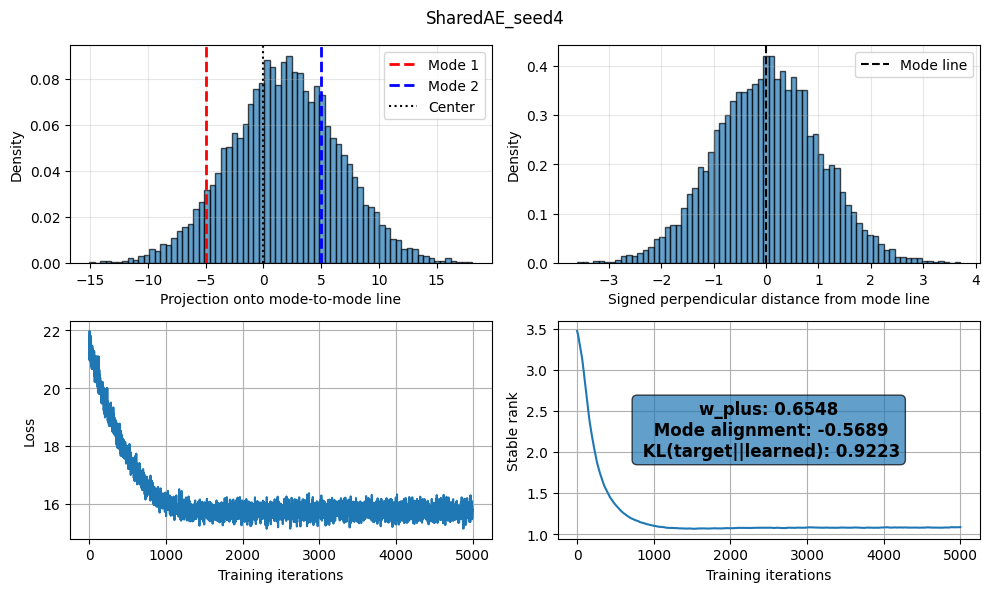

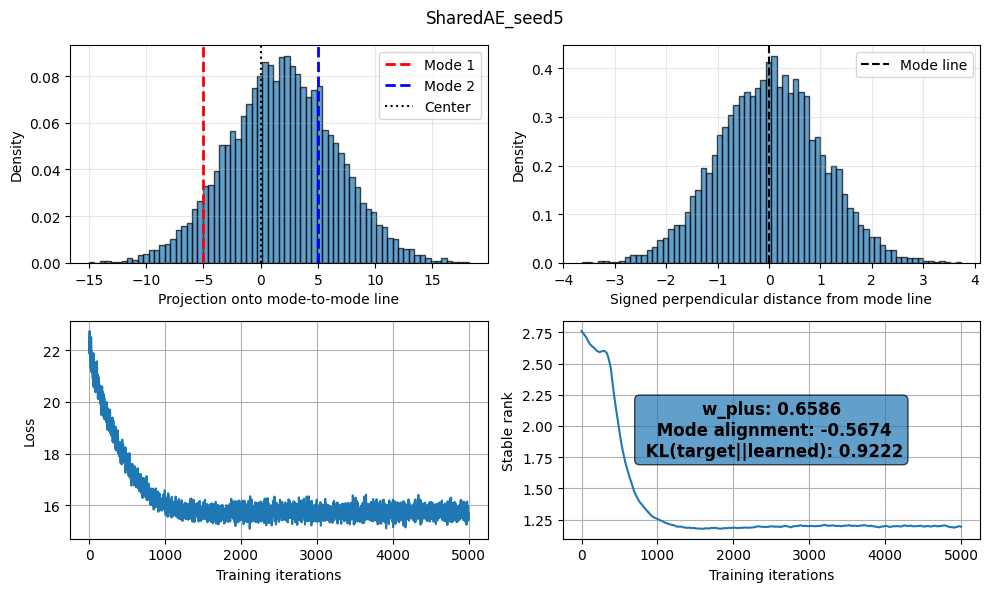

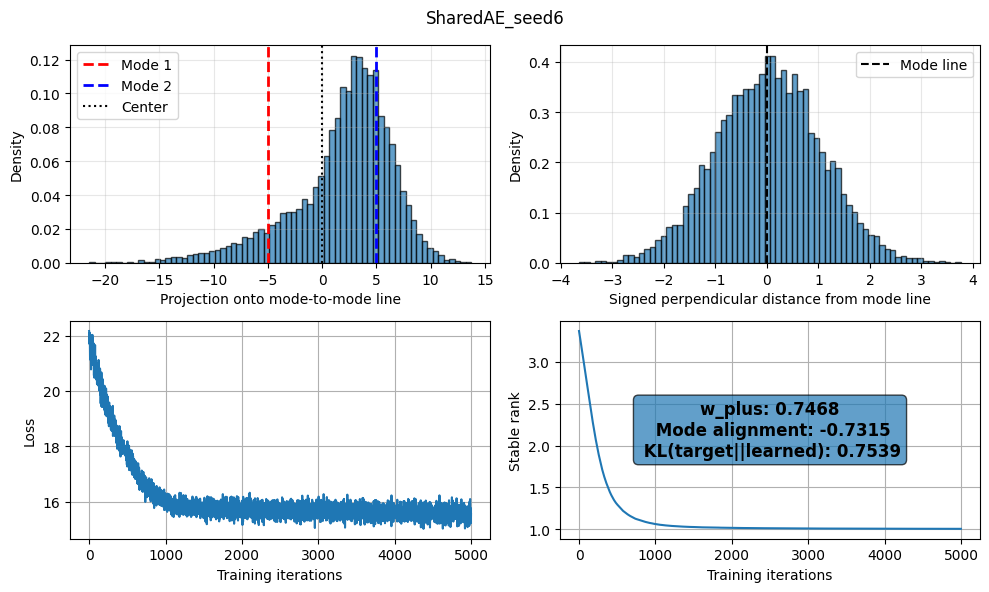

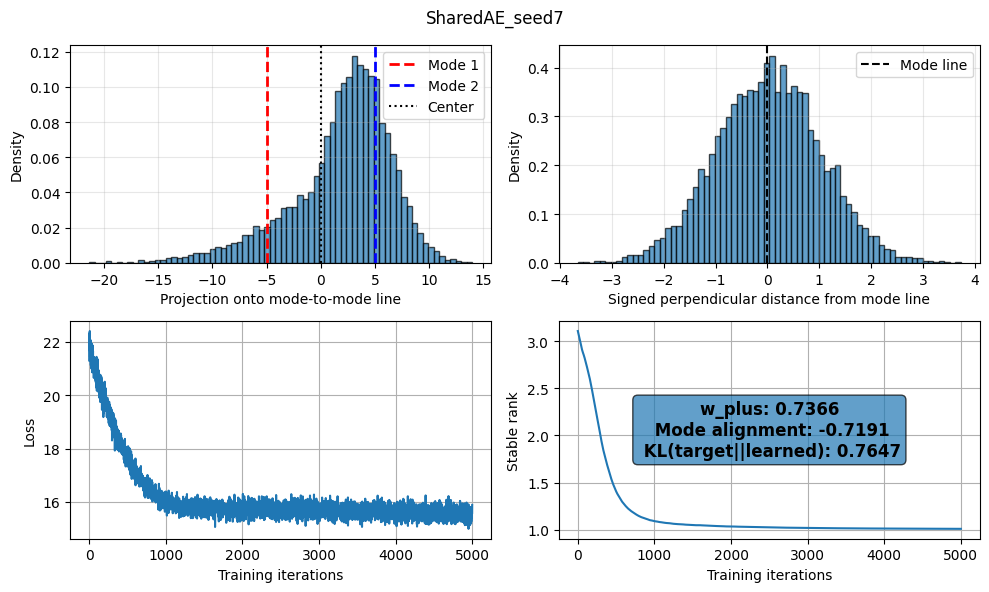

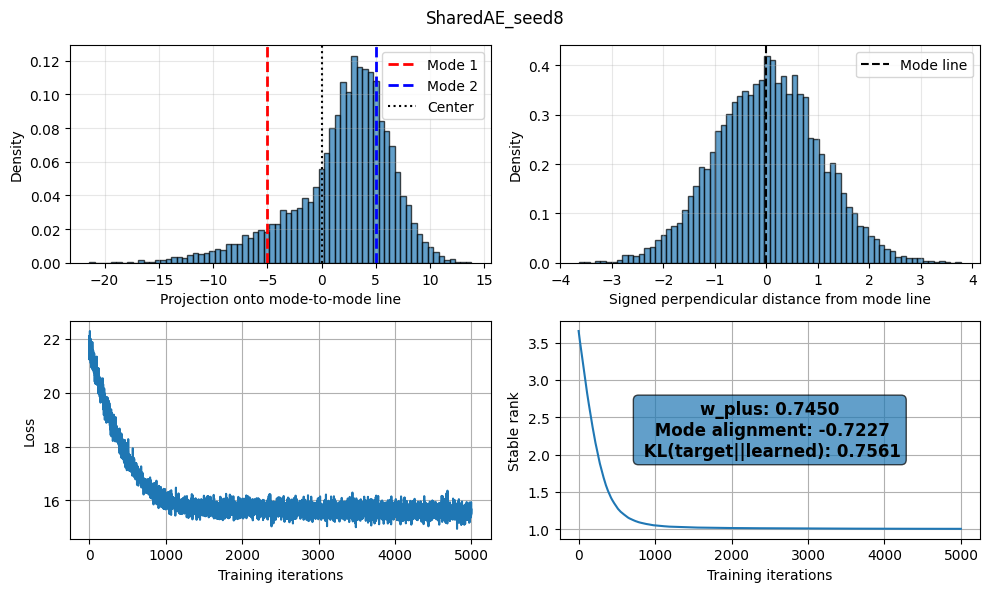

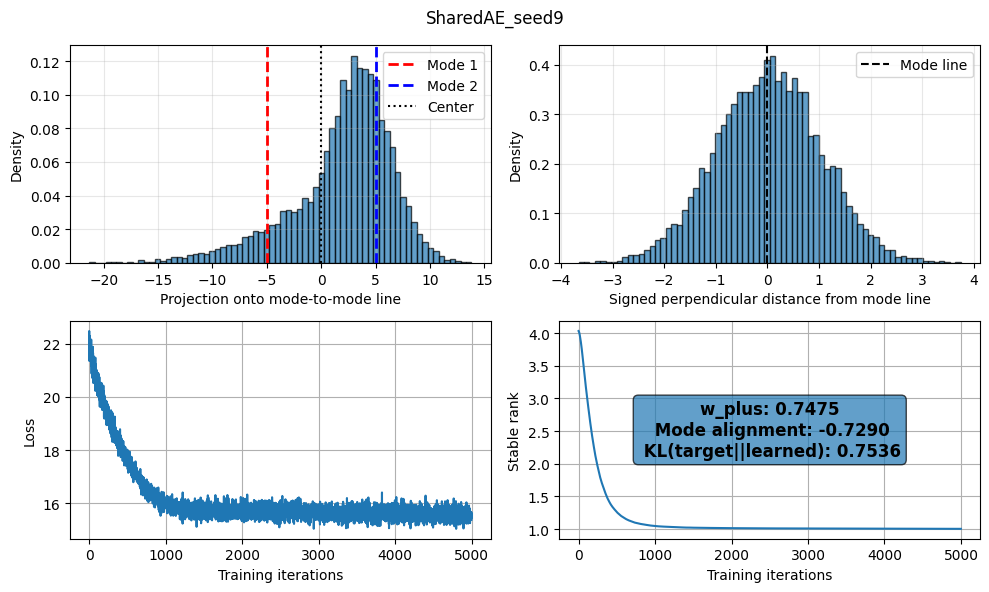

In [10]:
dim = 10
target_radius = 5
key = jax.random.PRNGKey(0)

# Define initial distribution
num_samples = 10000
initial_distribution = lambda key: jax.random.multivariate_normal(key, mean=jnp.zeros(dim), cov=jnp.identity(dim), shape=num_samples)
initial_distribution_pdf = lambda x: jax.scipy.stats.multivariate_normal.pdf(x, mean=jnp.zeros(dim), cov=jnp.identity(dim))
# initial_distribution = lambda key: sample_multimodal_gaussian(key, means=jnp.array([jnp.identity(dim)[0], jnp.identity(dim)[1]])*target_radius,
#                                                               covs=jnp.tile(jnp.identity(dim), (2, 1, 1)), weights=weights, num_samples=num_samples)
# initial_distribution_pdf = lambda x: multimodal_gaussian_pdf(x, means=jnp.array([jnp.identity(dim)[2], jnp.identity(dim)[3]])*target_radius,
#                                                               covs=jnp.tile(jnp.identity(dim), (2, 1, 1)), weights=jnp.array([0.5, 0.5]))

# Define target distribution
modes = jnp.array([jnp.identity(dim)[0], -jnp.identity(dim)[0]]) * target_radius
covs = jnp.tile(jnp.identity(dim), (2, 1, 1))
weights = jnp.array([0.3, 0.7])
target_sampler = lambda key: sample_multimodal_gaussian(key, modes, covs, weights, num_samples=num_samples)
target_distribution_pdf = lambda x: multimodal_gaussian_pdf(x, modes, covs, weights)
# target_sampler(key)
model_fname = "exploratory_experiments/MLP/models/LinearMLP_20D_5radius_orthogonal23_bimodalinit01_03weight_adamw1e-3_001init.eqx"


for i in range(10):
    model_fname = f"multi_seed_experiments/SharedAE_10D_10width_target0-0_radius5_weight3/SharedAE_seed{i}.eqx"

    # Skeleton pytrees
    dim = 10
    key = jax.random.PRNGKey(0)
    model_skeleton = SharedWeightAutoencoder(input_dim=dim, hidden_dim=10, activation=jax.nn.softplus, key=key)
  
    epochs = 5000
    losses_skeleton = jnp.empty(epochs)
    ranks_skeleton = jnp.empty(epochs)
    skeleton = {'model': model_skeleton,
                'losses': losses_skeleton,
                'weight_ranks': ranks_skeleton}

    loaded_data = eqx.tree_deserialise_leaves(model_fname, skeleton)
    loaded_model = loaded_data['model']
    loaded_losses = loaded_data['losses']
    loaded_ranks = loaded_data['weight_ranks']

    title = f'SharedAE_seed{i}'
    fig, axes = plot_analysis(loaded_model, key, initial_distribution, target_sampler, 
                            initial_distribution_pdf, target_distribution_pdf, modes, 
                            target_radius, loaded_losses, loaded_ranks, title=title)
    # fig.savefig(f'{title}.pdf', format='pdf')

In [16]:
jnp.argmin(loaded_ranks)

Array(285, dtype=int32)

In [56]:
target_modes

Array([[ 9.2977266e+00,  3.6813421e+00],
       [ 9.8961296e+00,  1.4375763e+00],
       [ 9.9826059e+00, -5.8954829e-01],
       [ 5.5994301e+00,  8.2853117e+00],
       [ 4.8367696e+00, -8.7524662e+00],
       [ 1.8937220e-03,  1.0000000e+01],
       [-9.0922918e+00,  4.1629591e+00],
       [-4.2406626e+00, -9.0563116e+00],
       [ 9.9997482e+00, -7.0945486e-02],
       [-9.9149284e+00,  1.3016099e+00]], dtype=float32)

In [28]:
jax.tree.leaves(eqx.filter(loaded_model, eqx.is_array))[0]

Array([[ 0.34815192, -1.440186  ],
       [ 1.0264022 , -0.6846706 ]], dtype=float32)